# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
This is a CV based lane-marker detection and tracking implementation using standard OpenCV packages and image processing functions. 

The entire pipeline is structured as follows and is implemented after some experimentation on robust color spaces to detect lane-marker lines under various occlusions (such as shadows). 

---
>**The lane marker line detector pipeline**
>1. *RoI Mask* -- limits further processing toi the expected lane line regions in captured image
>2. *Color Detect* -- identify white/yellow lane markers using HLS color-space transform
>3. *Gray Scale* -- translate to single channel gray-scale frame
>4. *Gaussian Blur* -- unsharp mask using Gaussian kernel before edge detection
>5. *Edge Detect* -- Canny edge detection
> 6. *Hough Line Transform* -- lane line stitching & detection using Hough transform
>7. *L/R Detect* -- Identify left & right lane markers using slope thresholds
>8. *Line Average* -- Average detected lines to smooth single frame detection
>9. *Lane Space Detect* -- lane and drivable space identification using OpenCV functions


## Import Packages

In [1]:
#importing some useful packages
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

print("Packages imported ...")

Packages imported ...


### Test Code
#### Color Space Selection

Experimeting with a few data sets of road markings ([ROMA (ROad MArkings) image database](http://perso.lcpc.fr/tarel.jean-philippe/bdd/index.html)), we select the HSL color space to robustly detect bopth yellow and white lane markings in various road and lighting conditions. 
The lane markings are robustly detceted by using both the L & S components from the transformed color space with appropriate thresholds. 

<Figure size 432x288 with 0 Axes>

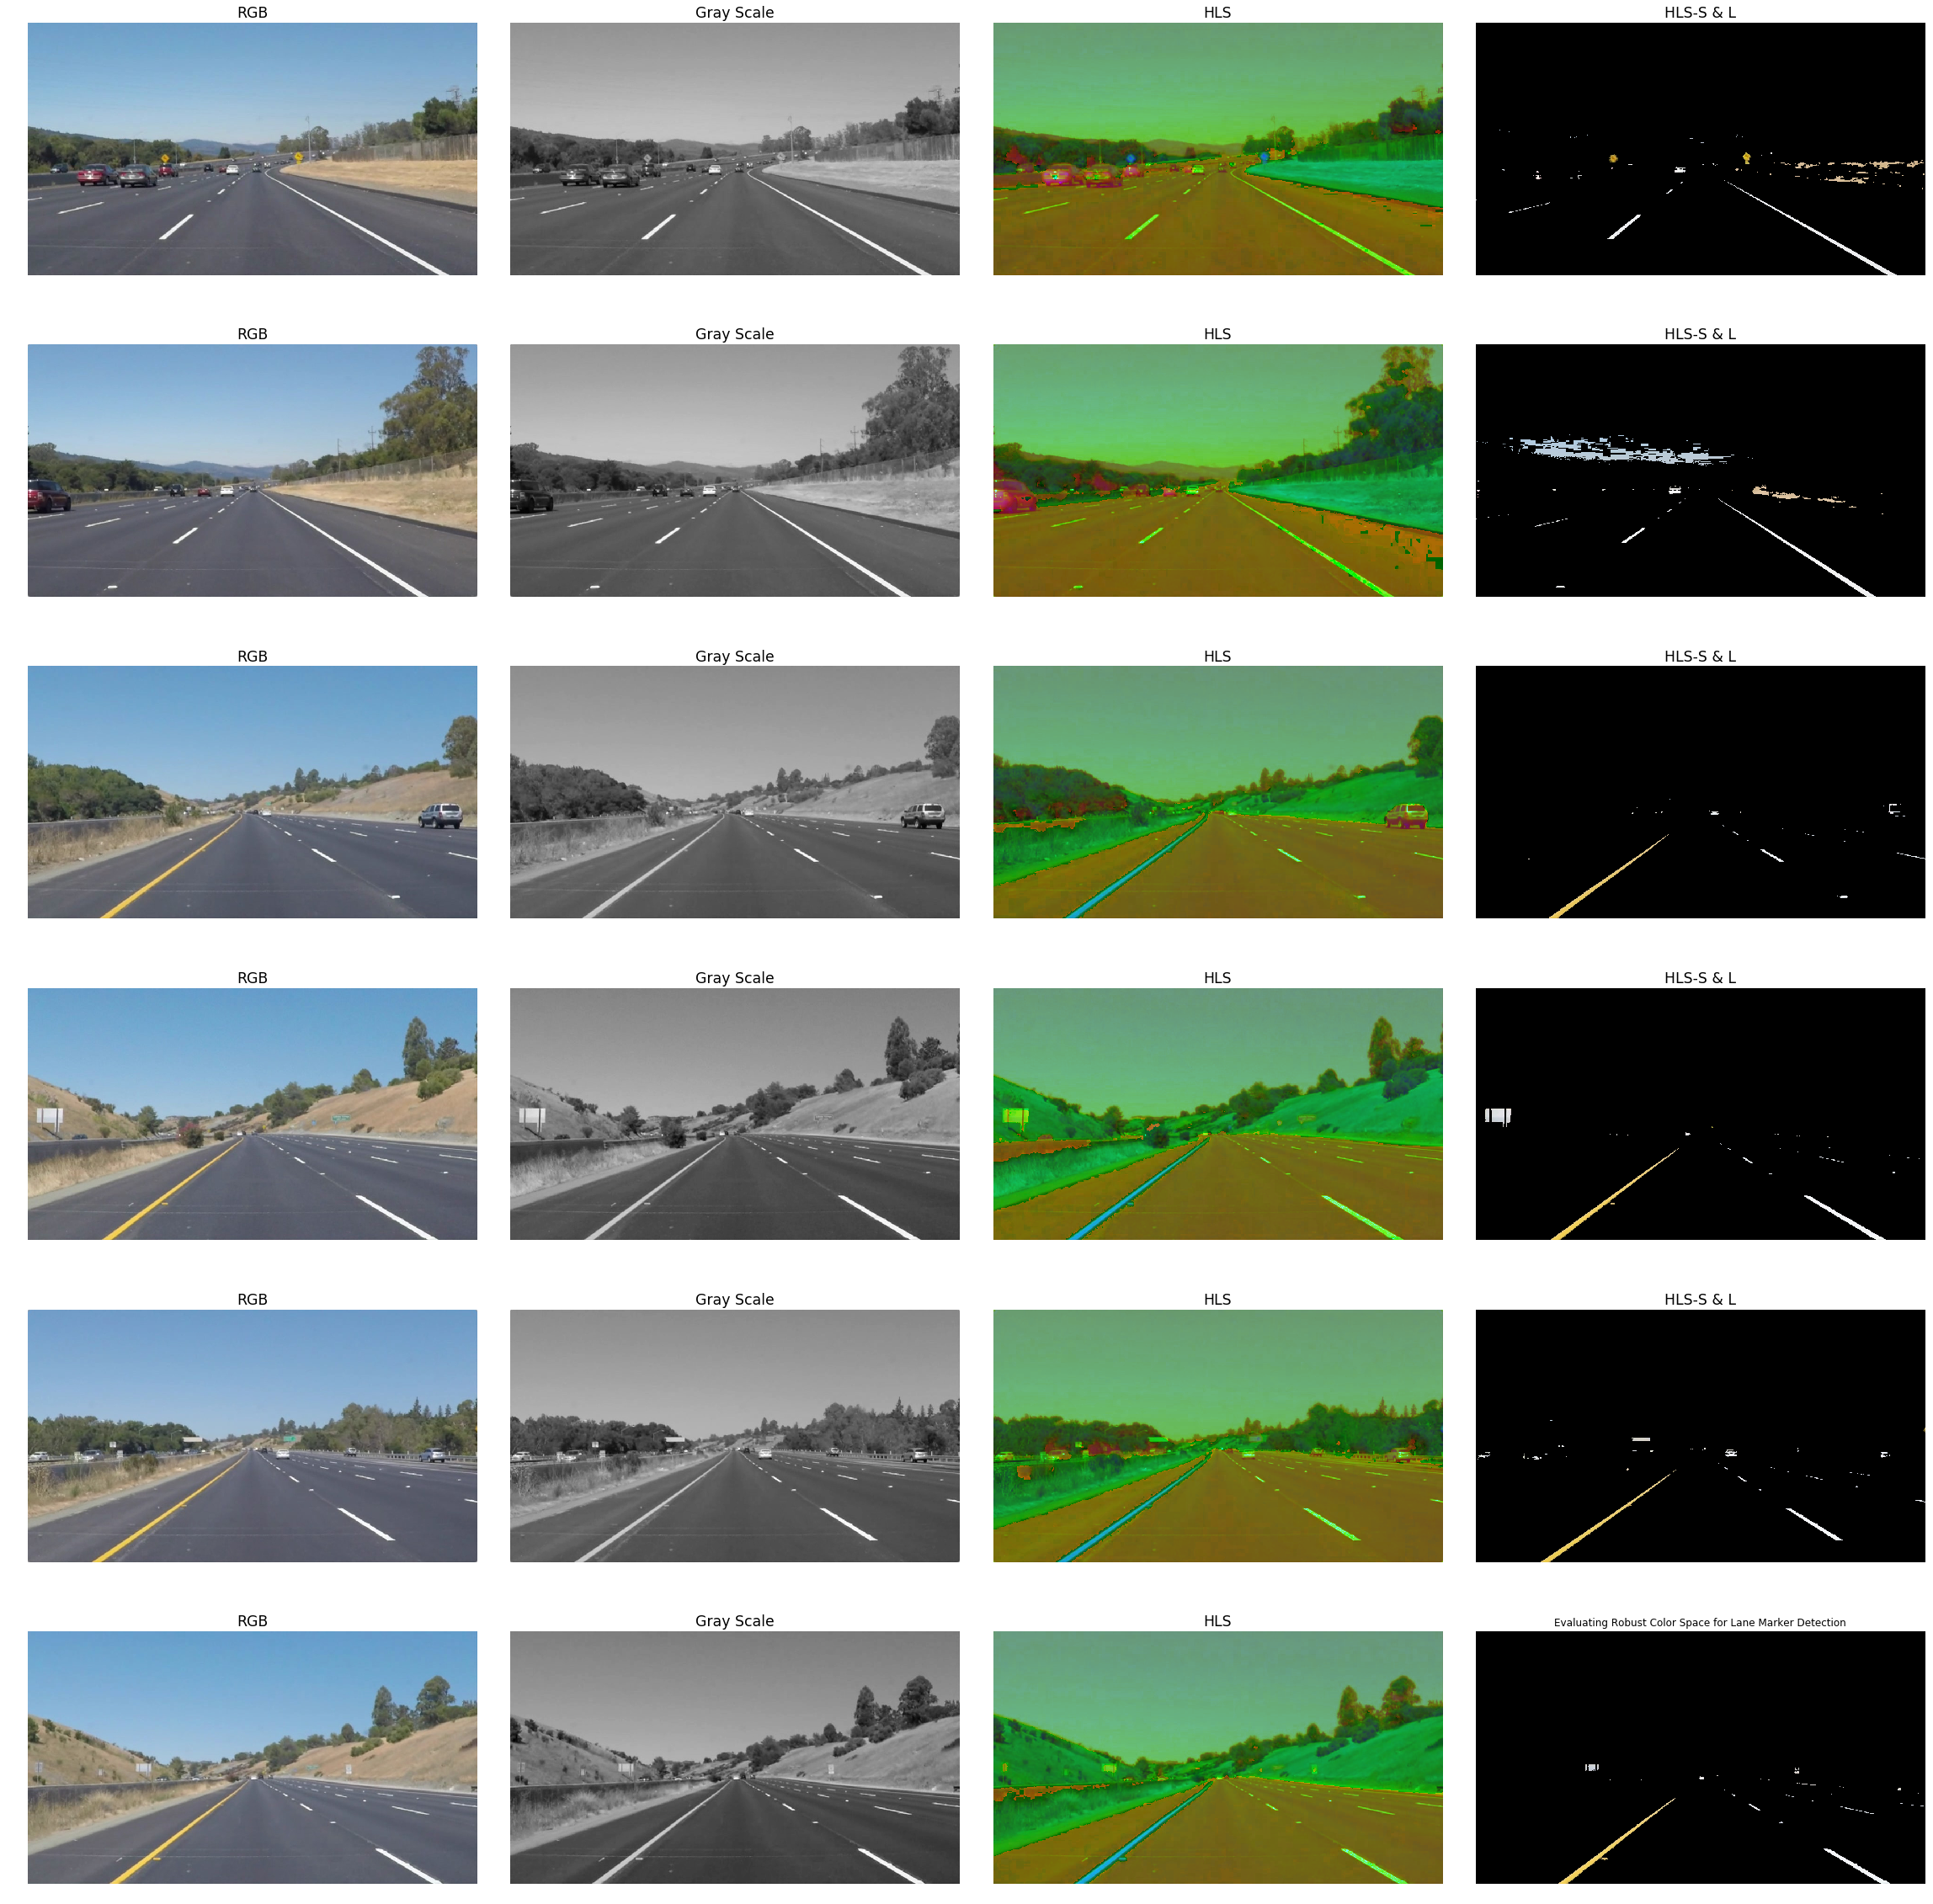

<Figure size 432x288 with 0 Axes>

In [2]:
# Compare RGB, Gray, HLS and HSV colro space to identify transformation 
#   that robustly detects lane marker lines

files = os.listdir("test_images/")
fig1 = plt.figure()
plt.subplots(figsize=(32,32))
nrows = len(files)
ncols = 4 # RGB, Gray, HLS(1 component), HSV(1 component)

for idx in range(len(files)):
    image = mpimg.imread("test_images/"+files[idx])
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    plt.subplot(nrows, ncols, idx*ncols+1)
    plt.imshow(image)
    plt.title("RGB", size="xx-large")
    plt.axis("off")
    plt.subplot(nrows, ncols, idx*ncols+2)
    plt.imshow(gray_img, cmap = "gray")
    plt.title("Gray Scale", size="xx-large")
    plt.axis("off")
    plt.subplot(nrows, ncols, idx*ncols+3)
    plt.imshow(hls_img)
    plt.title("HLS", size="xx-large")
    plt.axis("off")
    plt.subplot(nrows, ncols, idx*ncols+4)
    whitemask = cv2.inRange(hls_img, (0,200,0), (255,255,255))
    yellowmask = cv2.inRange(hls_img, (10,0,100), (40, 255, 255))  
    mask = cv2.bitwise_or(whitemask, yellowmask)
    img = cv2.bitwise_and(image, image, mask = mask)
    plt.imshow(img, cmap = "gray")
    plt.title("HLS-S & L", size="xx-large")
    plt.axis("off")
    
plt.title("Evaluating Robust Color Space for Lane Marker Detection")
plt.tight_layout()
plt.show()
plt.draw()

## Lane-Detector Pipeline

Following functions implement the entire CV pipeline that will bve applied to each frame of the captured video frame.

The underlying presumption is that we only process pixels that are *likely* to correpond to a lane marker in order to reduce processing workloads.

Though more advanced frame-averaging techniques are possible in order to temporally track lane markers, this is left for a future advanced implementation of the lane marker implementation. 

In [3]:
def define_roi(img, maskfit_factor_horiz, maskfit_factor_vert):
    # define region of interest, 4-sided polygon
    ysize = img.shape[0]
    xsize = img.shape[1]
    left_bottom = np.array([0, ysize])
    right_bottom = np.array([xsize, ysize])
    # check ROI top vertices don't cross
    if (xsize/maskfit_factor_horiz < xsize/2):
        left_top = np.array([xsize/maskfit_factor_horiz, ysize/maskfit_factor_vert])
        right_top = np.array([xsize-xsize/maskfit_factor_horiz, ysize/maskfit_factor_vert])
    else:
        left_top = np.array([xsize/2, ysize/maskfit_factor_vert])
        right_top = np.array([xsize/2, ysize/maskfit_factor_vert])
    
    return np.array([[left_bottom,left_top,right_top,right_bottom]], dtype=np.int32)

def roi_mask(img, vertices):
    """
    Applies an image mask.    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def color_detect(img):
    hlsimg = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # white color mask
    whitemask = cv2.inRange(hlsimg, (0,200,0), (255,255,255))
    # yellow color mask
    yellowmask = cv2.inRange(hlsimg, (10,0,100), (40, 255, 255))  
    # combine white+yellow
    mask = cv2.bitwise_or(whitemask, yellowmask)
    return cv2.bitwise_and(img, img, mask = mask)

def grayscale_convert(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size = 5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def edge_detect(img, low_threshold, high_threshold):
    """Applies the Canny edge detector transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def draw_lines(img, lines, color=[255, 255, 255], thickness=5):
    """
    Draw curved polylines given a set of points in an "image"   
    """
    #
    # Draw curves using polylines
    #
    lineslope_tol = 0.15 # out of range from 85% of 45 degrees
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            #cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
            
            # filter points that give lines too close to horizontal
            if (np.absolute(y2 - y1)/np.absolute(x2 - x1) <= lineslope_tol):
                x1 = x2 = y1 = y2 = -1 # out of scope
            pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
            cv2.polylines(img, [pts], True, color, thickness, lineType = cv2.LINE_AA, shift = 0)

    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def detect_leftright(lines):
    """
    Detect left & right "lanes" based on slope
    Note image dimensions are reversed hence left lanes appear with -ve slope
    """
    left_lines = []
    right_lines = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1)/(x2 - x1))
            # break if line is too horiz/vert (denoise)
            if (abs(slope) < .1) or (abs(slope) > 150):   
                continue
                
            # detect right vs left line    
            if slope >= 0: # RIGHT line
                right_lines.append(line)
            else: # LEFT line
                left_lines.append(line)

    return np.asarray(left_lines), np.asarray(right_lines)

def average_lines(image, vert_limit_factor, lines):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    Average slopes of input lines and weigh each line w/ the length of each
    Output a line array of size(1,4)
    Lower intercept point (ymin) is "0"
    Upper intercept point (yamx) is max of all detected y2 points in line
    """
    line_slp = []
    line_int = []
    line_len = []
    line_lft = []
    ymin = math.inf # bottom limit
    ymax = 0 # top limit
    yintercept = math.inf
    line_isleft = False
    
    if lines is None:
        return None
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            line_slope = (y2-y1)/(x2-x1)
            line_length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            line_intercept = intercept = y1 - line_slope * x1 # set yintercept  
            if (line_slope < 0): line_isleft = True 
            else: line_isleft = False
                    
            # break if line is too horiz/vert (denoise)
            if (abs(line_slope) < .1) or (abs(line_slope) > 150):   
                continue
           
            # generate array of detected line attributes
            line_slp.append(line_slope)
            line_int.append(line_intercept)
            line_len.append(line_length)
            line_lft.append(line_isleft)
                    
    # weigh each line slope with its length and find average of lines
    if len(line_len) > 0:
        slope = np.average(line_slp, 0, line_len)
        intercept = np.average(line_int, 0, line_len)
    else: # out of scope
        slope = 0
        intercept = image.shape[0]
        
    # make average line with slope line_slp and intercepts ymin & ymax
    ymin = image.shape[0]
    ymax = ymin / vert_limit_factor
    if (slope != 0):
        avg_x1 = int((ymin - intercept)/slope)
        avg_x2 = int((ymax - intercept)/slope)
    else: # need robustness check here, useopreviously detected or (default) x1 x2 value        
        #check for left or right lane
        if (line_isleft):
            avg_x1 = 50
        else: 
            avg_x1 = image.shape[1] - 50
        avg_x2 = image.shape[1]/2 # middle of image
        #need robustness check here, use previously detected or (default) x1 x2 value
    avg_y1 = int(ymin)
    avg_y2 = int(ymax)
        
    return np.array([avg_x1, avg_y1, avg_x2, avg_y2], dtype=np.int32)

def weighted_image(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

### CV Processing Pipeline Test

Test pipeline on single frame images in the directory "test_images". 

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

parameters in th epipeline implementation such as color detector thresholds (HLS color space), blur kernel sizes, Canny edge detector thresholds as well as the Hough-line Transform parameters were tuned on the test set to ensure robust detection of lane markers. 

To simplify the call structure and for simplicity in the program, most of these *tuned* paramaters are hard-coded in the pipeline implmentation. In a real system, these would be available as extrernal knobs to fine-tune performance under various drive scenarios and environmental conditions (night, foggy, specular light source etc.)

#### Pipeline Implementation


In [4]:
def process_image(image, roi_horiz_factor = 2.5, roi_vert_factor = 1.67):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # Read in image dimensions
    ysize = image.shape[0]
    xsize = image.shape[1]

    #
    # Pre-process (white-yellow detect, gray, canny edge)
    #
    vertices = define_roi(image, roi_horiz_factor, roi_vert_factor) # 4-sided polygon, horiz & vert thresholds
    roi_image = roi_mask(image, vertices)
    whiteyellow = color_detect(roi_image)
    gray = grayscale_convert(whiteyellow)
    blur = gaussian_blur(gray, 7) # kernel size
    edges = edge_detect(blur, 50, 150) # thresholds for Canny operator        
    
    #
    # RoI define & mask w/ Hough-lines
    #
    # Overlay original with hough-line detect
    #vertices = define_roi(edges, roi_horiz_factor, roi_vert_factor) # 4-sided polygon, horiz & vert thresholds
    #masked_image = mask_roi(edges, vertices)
    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 35     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines = hough_lines(edges, rho, theta, threshold, min_line_length, max_line_gap)
    houghed = draw_lines(image, lines)
    
    #
    # Filter Houghlines for curves and 
    #
    left_lines, right_lines = detect_leftright(lines)    
    left_lane = average_lines(image, roi_vert_factor, left_lines)
    right_lane = average_lines(image, roi_vert_factor, right_lines)
    cv2.line(image, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), [255, 0, 0], thickness=5, lineType=cv2.LINE_AA)
    cv2.line(image, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), [0, 0, 255],  thickness=5, lineType=cv2.LINE_AA)

    #
    # Overlay LEFT+RIGHT lane-markers with image ("drivable space")
    #
    # generate 4-sided polygon to fill "drivable" lane space 
    # co-ordinates clockwise from bottom left [(x1,y1), (x2,y2), (x4,y4), (x3,y3)]
    x1, y1, x2, y2 = left_lane
    x4, y4, x3, y3 = right_lane
    # check for left & right lanes crossing
    if (x3 < x2): x3 = x2
    if (y3 != y2): y2 = y3 = np.amax([y2, y3])
    points = np.array([(x1,y1), (x2,y2), (x3,y3), (x4,y4)], dtype=np.int32)
    lane_image = np.zeros((ysize, xsize, 3), dtype=np.uint8)
    cv2.fillConvexPoly(lane_image, points, [50, 205, 50]) 
    overlaid_image = weighted_image(lane_image, image, α=1., β=.4, γ=0.)
    
    return overlaid_image

#### Process Test Images Using CV Pipeline

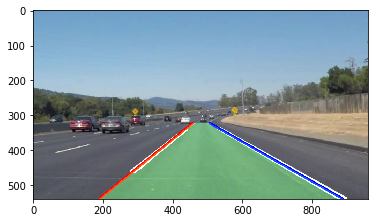

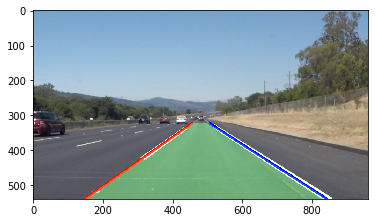

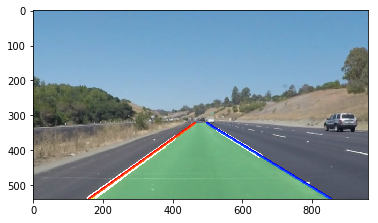

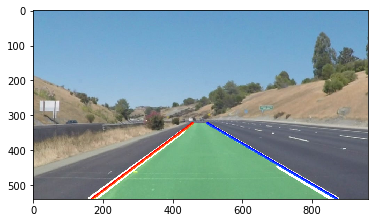

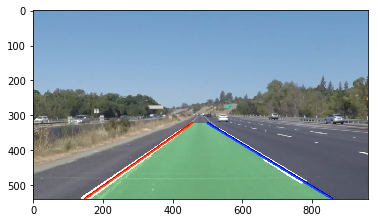

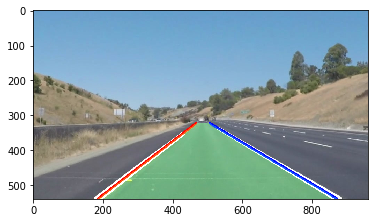

In [5]:
import os

files = os.listdir("test_images/")


for file in files:
    if file[0:6] != "output":
        image = mpimg.imread("test_images/"+file)
        #print(image.shape)        
        #
        # Process "camera' Fov as image slices from bottom to top
        #
        #image_slice = np.split(image, image.shape[0]/8, axis=0)  # first split into 8x240, 8x240,... sub-arrays, i.e., split by rows of 8 first.
        #np.asarray(image_slice)
        #image_slice = image[280:540,:,:]
        #print(image_slice.shape)    
        #image_slice = image([320:540,:,:]) # horizontal slice from bottom
        image_slice = image
        
        #
        # Final image merge with lane markers
        #
        overlaid_image = process_image(image_slice, 2.5, 1.67) # RoI factors for whole frame (set to 1. for image slices)       
        # write processed image to file
        b,g,r = cv2.split(overlaid_image)
        result = cv2.merge((r,g,b))
        cv2.imwrite("test_images_output/"+file, result)
        plt.figure()
        plt.imshow(overlaid_image)

## Test on Videos

In [6]:
files = os.listdir("test_videos/")

for file in files:
    #white_output = 'test_videos_output/solidWhiteRight.mp4'
    white_output = "test_videos_output/"+file
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    clip1 = VideoFileClip("test_videos/"+file)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:24<00:00, 10.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 26.4 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 22.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:32<00:00, 21.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 33.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))